In [63]:
import random
import numpy as np
import json
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from collections import Counter
import time
import os
import pandas as pd
from scipy.signal import correlate
import matplotlib.pyplot as plt
np. set_printoptions(threshold=np. inf)

In [52]:
# Permanently changes the pandas settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [53]:
date = 'Oct6th-reduced2-'
filename = ''.join((date,'scan_stats_SPADE.json'))
filename

'Oct6th-reduced2-scan_stats_SPADE.json'

In [54]:
import scan
import simulate_data

In [55]:
default_params = {
    'M':2,
    'N':40,
    'D':51,
    'T':1000,
    'seed':0,
    'SM_repetitions':5,
    'spikes_in_SM':8,
    'noise':500
}
scan_dict = {
    'SM_repetitions':[2,3,5,8,13],
    'spikes_in_SM':[2,4,8,16],
    'noise':[0,50,100,500,1000]
}

In [56]:
param_combinations = []
for param_name, param_values in scan_dict.items():
    for param_value in param_values:
        params = default_params.copy()
        params[param_name] = param_value
        param_combinations.append(params)

In [57]:
len(param_combinations)

14

In [58]:
# Special SPADE packages...
import quantities as pq
import neo
import elephant
import viziphant
from neo.core import SpikeTrain

In [59]:
def do_spade(spike_trains, win_size):
    output = elephant.spade.spade(spike_trains, bin_size=pq.ms, winlen=win_size,
        output_format='concepts',n_surr=1000 ,alpha=0.05)

    patterns = output['patterns']
    pvalue_spectrum = output['pvalue_spectrum']
    non_sgnf_sgnt = output['non_sgnf_sgnt']

    patterns = elephant.spade.pattern_set_reduction(patterns,non_sgnf_sgnt,win_size,pvalue_spectrum)
    patterns = elephant.spade.concept_output_to_patterns(patterns, win_size, pq.ms)
    
    spade_patterns = []
    for pattern in patterns:
        spade_patterns.append(np.array([np.sort(np.array(pattern['itemset'])) % win_size, np.sort(np.array(pattern['neurons']))]).T)
        
    return spade_patterns

In [60]:
import numpy as np
import random
import os
import pandas as pd
import json
from tqdm import tqdm

# Define default parameters and scan values
default_params = {
    'M':1,
    'N':100,
    'D':71,
    'T':1000,
    'seed':0,
    'SM_repetitions':5,
    'spikes_in_SM':20,
    'noise':500
}
scan_dict = {
    'noise':[0,100,200,300,400]
}

# Generate all parameter combinations
param_combinations = []
for param_name, param_values in scan_dict.items():
    for param_value in param_values:
        params = default_params.copy()
        params[param_name] = param_value
        param_combinations.append(params)

num_samples = len(param_combinations)
results = []
trials=5

# Iterate through parameter combinations
for idx, params in tqdm(enumerate(param_combinations[:5])):
    for trial in range(trials):

        if os.path.isfile(filename):
            df = pd.read_json(filename)
            with open(filename, 'r') as results_file:
                results = json.load(results_file)
        params['seed'] = (trial+1)*(idx+1)
        print(params)
        A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse = simulate_data.generate_synthetic_data(params)
        print(len(A_sparse[0]))

        start = time.time()
        spike_trains = [SpikeTrain(A_sparse[1][A_sparse[0]==n] ,units= pq.ms, t_stop=params['T']) for n in range(params['N'])]
        
        spade_patterns = do_spade(spike_trains, params['D'])
        win_size = (K_dense.shape[0],1+max([max(k[:,0]) for k in spade_patterns]))
        spade_imgs = np.zeros((*win_size,len(spade_patterns)))
        
        for p, pattern in enumerate(spade_patterns):
            for (i,j) in pattern: 
                spade_imgs[j,i,p] = 1

        SM_acc, cc = simulate_data.get_acc(K_dense,spade_imgs)


        end = time.time()

        window_time = np.nan
        cluster_time = np.nan
        sequence_time = np.nan

        result = {
            'idx':idx,
            'seed':params['seed'],
            'M':params['M'],
            'N':params['N'],
            'D':params['D'],
            'T':params['T'],
            'SM_repetitions':params['SM_repetitions'],
            'spikes_in_SM':params['spikes_in_SM'],
            'noise':params['noise'],
            'window_time': window_time,
            'cluster_time': cluster_time,
            'sequence_time': sequence_time,
            'total_time': end-start,
            'total_spikes':len(A_sparse[1]),
            'total_patterns':len(spade_patterns),
            'SM_acc':SM_acc.tolist()
        }
        results.append(result)

        with open(filename, 'w') as results_file:
            json.dump(results, results_file, indent=4)


0it [00:00, ?it/s]

{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 1, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 0}
100
Time for data mining: 0.08151555061340332
Time for pvalue spectrum computation: 249.63292121887207
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 2, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 0}
100
Time for data mining: 0.06911849975585938
Time for pvalue spectrum computation: 235.0671148300171
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 3, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 0}
100
Time for data mining: 0.055008649826049805
Time for pvalue spectrum computation: 238.71997356414795
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 4, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 0}
100
Time for data mining: 0.08027124404907227
Time for pvalue spectrum computation: 231.18658542633057
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 5, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 0}
100
Time for data mining: 0.05988430976867676


1it [19:44, 1184.90s/it]

Time for pvalue spectrum computation: 229.4704086780548
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 2, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 100}
200
Time for data mining: 0.09598684310913086
Time for pvalue spectrum computation: 289.1523344516754
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 4, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 100}
200
Time for data mining: 0.09674215316772461
Time for pvalue spectrum computation: 298.2660446166992
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 6, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 100}
200
Time for data mining: 0.09092187881469727
Time for pvalue spectrum computation: 321.9968318939209
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 8, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 100}
200
Time for data mining: 0.13246870040893555
Time for pvalue spectrum computation: 314.23652601242065
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 10, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 100}
200
Time 

2it [45:09, 1384.50s/it]

Time for pvalue spectrum computation: 299.49959659576416
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 3, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 200}
300
Time for data mining: 0.18385601043701172
Time for pvalue spectrum computation: 446.2736904621124
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 6, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 200}
300
Time for data mining: 0.2223656177520752
Time for pvalue spectrum computation: 407.0285875797272
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 9, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 200}
300
Time for data mining: 0.6271159648895264
Time for pvalue spectrum computation: 400.85382890701294
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 12, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 200}
300
Time for data mining: 0.15208649635314941
Time for pvalue spectrum computation: 401.9454426765442
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 15, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 200}
300
Time 

3it [1:19:24, 1690.81s/it]

Time for pvalue spectrum computation: 397.26094579696655
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 4, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 300}
400
Time for data mining: 0.2992222309112549
Time for pvalue spectrum computation: 515.7078692913055
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 8, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 300}
400
Time for data mining: 0.31203460693359375
Time for pvalue spectrum computation: 521.4280273914337
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 12, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 300}
400
Time for data mining: 0.2340843677520752
Time for pvalue spectrum computation: 481.4994430541992
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 16, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 300}
399
Time for data mining: 0.4279477596282959
Time for pvalue spectrum computation: 633.7292251586914
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 20, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 300}
400
Time f

4it [2:10:24, 2231.27s/it]

Time for pvalue spectrum computation: 904.8430242538452
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 5, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 400}
500
Time for data mining: 0.7098941802978516
Time for pvalue spectrum computation: 1254.346447944641
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 10, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 400}
500
Time for data mining: 1.2845430374145508
Time for pvalue spectrum computation: 1332.8878648281097
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 15, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 400}
500
Time for data mining: 0.8284945487976074
Time for pvalue spectrum computation: 1316.3680305480957
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 20, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 400}
500
Time for data mining: 6.771681547164917
Time for pvalue spectrum computation: 2366.905736684799
{'M': 1, 'N': 100, 'D': 71, 'T': 1000, 'seed': 25, 'SM_repetitions': 5, 'spikes_in_SM': 20, 'noise': 400}
500
Time f

5it [4:19:02, 3108.56s/it]

Time for pvalue spectrum computation: 1436.5344307422638


In [64]:
with open(filename, 'w') as results_file:
    json.dump(results, results_file, indent=4)

In [61]:
df = pd.DataFrame(results)
df

,idx,seed,M,N,D,T,SM_repetitions,spikes_in_SM,noise,window_time,cluster_time,sequence_time,total_time,total_spikes,total_patterns,SM_acc
0,0,1,1,100,71,1000,5,20,0,NaN,NaN,NaN,249.795745,100,1,[1.0]
1,0,2,1,100,71,1000,5,20,0,NaN,NaN,NaN,235.209036,100,1,[1.0]
2,0,3,1,100,71,1000,5,20,0,NaN,NaN,NaN,238.833705,100,1,[1.0]
3,0,4,1,100,71,1000,5,20,0,NaN,NaN,NaN,231.338896,100,1,[1.0]
4,0,5,1,100,71,1000,5,20,0,NaN,NaN,NaN,229.605345,100,1,[1.0]
5,1,2,1,100,71,1000,5,20,100,NaN,NaN,NaN,289.309554,200,1,[1.0]
6,1,4,1,100,71,1000,5,20,100,NaN,NaN,NaN,298.455340,200,1,[1.0]
7,1,6,1,100,71,1000,5,20,100,NaN,NaN,NaN,322.164241,200,1,[1.0]
8,1,8,1,100,71,1000,5,20,100,NaN,NaN,NaN,314.440743,200,1,[1.0]
9,1,10,1,100,71,1000,5,20,100,NaN,NaN,NaN,299.674686,200,1,[1.0]


In [42]:
df.groupby(["noise"])['total_time'].mean(),df.groupby(["noise"])['total_time'].std()

(noise
 0      25.540772
 100    31.289507
 200    38.089195
 300    51.278420
 400    66.892221
 Name: total_time, dtype: float64,
 noise
 0      1.083675
 100    0.672471
 200    0.871292
 300    1.919880
 400    1.546825
 Name: total_time, dtype: float64)

In [73]:
[100,200,300,400,500]

array([100, 100, 100, 100, 100, 200, 200, 200, 200, 200, 300, 300, 300,
       300, 300, 400, 400, 400, 399, 400, 500, 500, 500, 500, 500],
      dtype=int64)

In [93]:
df.groupby(['noise'])['total_spikes'].mean().index.to_numpy()+100

array([100, 200, 300, 400, 500], dtype=int64)

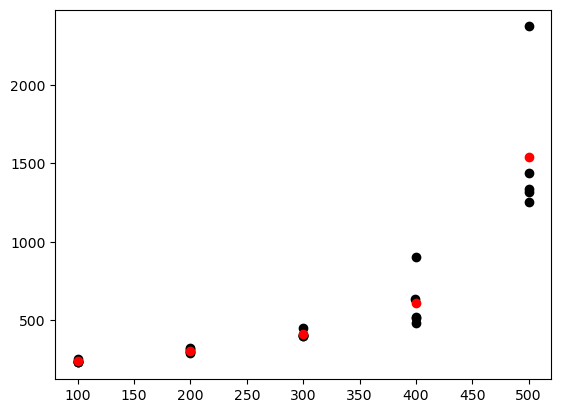

In [94]:
plt.figure()
plt.scatter(df['total_spikes'],df['total_time'],c='black')
plt.scatter(df.groupby(['noise'])['total_spikes'].mean().index.to_numpy()+100,df.groupby(['noise'])['total_time'].mean(),c='red')
plt.show()

In [24]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print(correlation_matrix)

                        M         N         D   T  num_SM_events  \
M                1.000000 -0.019511 -0.003807 NaN      -0.022546   
N               -0.019511  1.000000 -0.003488 NaN      -0.020657   
D               -0.003807 -0.003488  1.000000 NaN      -0.004031   
T                     NaN       NaN       NaN NaN            NaN   
num_SM_events   -0.022546 -0.020657 -0.004031 NaN       1.000000   
SM_total_spikes -0.024370 -0.022329 -0.004357 NaN      -0.025802   
noise           -0.031629 -0.028979 -0.005655 NaN      -0.033487   
window_time      0.331701 -0.062696  0.011927 NaN       0.448662   
cluster_time     0.404064  0.059379 -0.059149 NaN       0.476124   
sequence_time   -0.049144 -0.004694 -0.015947 NaN       0.010094   
total_time       0.118995 -0.006469  0.026695 NaN       0.410689   
total_patterns  -0.102824  0.030625 -0.003024 NaN      -0.030117   

                 SM_total_spikes     noise  window_time  cluster_time  \
M                      -0.024370 -0.031629

C:\Users\miles\AppData\Local\Temp\ipykernel_20648\2448198415.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


In [ ]:
plt.figure